### Loading images
https://www.tensorflow.org/tutorials/load_data/images

In [47]:
from __future__ import absolute_import, division, print_function, unicode_literals
import datetime
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard, LearningRateScheduler
import matplotlib.pyplot as plt
import resnet

AUTOTUNE = tf.data.experimental.AUTOTUNE

import IPython.display as display
from PIL import Image
import numpy as np
import os
import pathlib

%matplotlib inline

In [48]:
# To make some of the conda packages work (Tensorboard and pydot)
PATH = os.getenv('PATH')
%env PATH=/home/henrik/anaconda3/envs/TF2/bin:$PATH

env: PATH=/home/henrik/anaconda3/envs/TF2/bin:/home/henrik/anaconda3/envs/TF2/bin:/home/henrik/anaconda3/bin:/home/henrik/anaconda3/condabin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin


In [49]:
NUM_GPUS = 1
BS_PER_GPU = 128
BATCH_SIZE = 128
NUM_EPOCHS = 10

IMG_HEIGHT = 128
IMG_WIDTH = 128
NUM_CHANNELS = 3
#NUM_TRAIN_SAMPLES = 40000

BASE_LEARNING_RATE = 0.1
LR_SCHEDULE = [(0.1, 30), (0.01, 45)]

In [50]:
def preprocess(x, y):
  x = tf.image.per_image_standardization(x)
  return x, y


def augmentation(x, y):
    x = tf.image.resize_with_crop_or_pad(
        x, IMG_HEIGHT + 8, IMG_WIDTH + 8)
    x = tf.image.random_crop(x, [IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS])
    x = tf.image.random_flip_left_right(x)
    return x, y	


def schedule(epoch):
  initial_learning_rate = BASE_LEARNING_RATE * BS_PER_GPU / 128
  learning_rate = initial_learning_rate
  for mult, start_epoch in LR_SCHEDULE:
    if epoch >= start_epoch:
      learning_rate = initial_learning_rate * mult
    else:
      break
  tf.summary.scalar('learning rate', data=learning_rate, step=epoch)
  return learning_rate

In [51]:
data_dir = pathlib.Path('/mnt/sdb/augere_export_class/')

DATASET_SIZE = len(list(data_dir.glob('[!Anatomic]*/*.png')))
class_names = np.array([item.name for item in data_dir.glob('*') if item.name != 'metadata.json'])
# Remove 'anatomic landmarks'
class_names = np.delete(class_names, 0)

NUM_CLASSES = len(class_names)

print ("Class names: ",class_names)

Class names:  ['Unknown' 'Protruding lesions' 'Flat lesions' 'Lumen' 'Mucosa' 'Normal'
 'Excavated lesions']


In [52]:
# Create a dataset of the file paths
list_ds = tf.data.Dataset.list_files(str(data_dir/'[!Anatomic]*/*'))

In [53]:
samples_per_class = []

for class_name in class_names:
    class_samples = len(list(data_dir.glob(class_name+'/*.png')))
    samples_per_class.append(class_samples)
    print('{0:18}: {1:3d}'.format(class_name, class_samples))

print ('\nTotal number of images:', DATASET_SIZE)

# If one class contains more than half of the entire sample size
if np.max(samples_per_class) > DATASET_SIZE//2:
    print ("But the dataset is mainly shit")

Unknown           : 177
Protruding lesions: 583
Flat lesions      : 908
Lumen             : 1446
Mucosa            : 251
Normal            : 33129
Excavated lesions : 1252

Total number of images: 37746
But the dataset is mainly shit


In [54]:
def get_label_test(file_path):
    # Not used, mainly for log
    label = [i for i, s in enumerate(class_names) if 'Normal' in s]
    return np.uint8(label)
    
def get_label_int(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # get class integer from class-list
    label_int64 = tf.reduce_min(tf.where(tf.equal(parts[-2], class_names)))
    # cast to tensor array with dtype=uint8
    label_uint8 = tf.dtypes.cast(label_int64, tf.uint8)
    return tf.reshape(label_uint8, [-1])

def get_label_bool(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    return parts[-2] == class_names

def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

def process_path(file_path):
    label = get_label_int(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

Showing an example image/label pair

<Figure size 432x288 with 0 Axes>

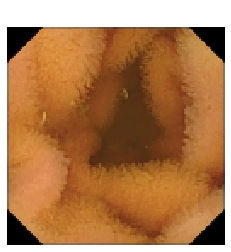

In [55]:
def show_image(img):
    for image, label in img:
        plt.figure()
        plt.figure(frameon=False, facecolor='white')
        plt.title(class_names[label.numpy()][0], fontdict={'color':'white','size':20})
        plt.imshow(image.numpy())
        plt.axis('off')

show_image(labeled_ds.take(1))

## Training
See https://lambdalabs.com/blog/tensorflow-2-0-tutorial-01-image-classification-basics/

https://github.com/lambdal/TensorFlow2-tutorial/tree/master/01-basic-image-classification

Splitting into training, test and validation data

In [56]:
train_size = int(0.7 * DATASET_SIZE)
val_size = int(0.15 * DATASET_SIZE)
test_size = int(0.15 * DATASET_SIZE)

shuffled_ds = labeled_ds.shuffle(buffer_size=10000)

train_ds = shuffled_ds.take(train_size)
test_ds = shuffled_ds.skip(train_size)
val_ds = test_ds.skip(val_size)
test_ds = test_ds.take(test_size)

In [57]:
def get_size(ds):
    return tf.data.experimental.cardinality(ds).numpy()

print ("{:32} {:>5}".format("Full dataset sample size:", get_size(shuffled_ds)))
print ("{:32} {:>5}".format("Train dataset sample size:", get_size(train_ds)))
print ("{:32} {:>5}".format("Test dataset sample size:", get_size(test_ds)))
print ("{:32} {:>5}".format("Validation dataset sample size:", get_size(val_ds)))

Full dataset sample size:        37746
Train dataset sample size:       26422
Test dataset sample size:         5661
Validation dataset sample size:   5663


In [58]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=3000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
      if isinstance(cache, str):
        ds = ds.cache(cache)
      else:
        ds = ds.cache()

    #ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever
    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

# Create training dataset
train_ds = prepare_for_training(train_ds, cache="./cache/resnet_train_ds.tfcache")
# Create test dataset
test_ds = prepare_for_training(test_ds, cache="./cache/resnet_test_ds.tfcache")
# Create validation dataset
val_ds = prepare_for_training(val_ds, cache="./cache/restnet_val_ds.tfcache")

In [59]:
tf.random.set_seed(22)
#train_dataset = train_dataset.map(augmentation).map(preprocess).shuffle(NUM_TRAIN_SAMPLES).batch(BS_PER_GPU * NUM_GPUS, drop_remainder=True)
#test_dataset = test_dataset.map(preprocess).batch(BS_PER_GPU * NUM_GPUS, drop_remainder=True)

input_shape = (IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS)
img_input = tf.keras.layers.Input(shape=input_shape)
opt = keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)

if NUM_GPUS == 1:
    model = resnet.resnet56(img_input=img_input, classes=NUM_CLASSES)
    model.compile(
              optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])
else:
    mirrored_strategy = tf.distribute.MirroredStrategy()
    with mirrored_strategy.scope():
      model = resnet.resnet56(img_input=img_input, classes=NUM_CLASSES)
      model.compile(
                optimizer=opt,
                loss='sparse_categorical_crossentropy',
                metrics=['sparse_categorical_accuracy'])  

log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
file_writer = tf.summary.create_file_writer(log_dir + "/metrics")
file_writer.set_as_default()

tensorboard_callback = tf.keras.callbacks.TensorBoard(
  log_dir=log_dir,
  update_freq='batch',
  histogram_freq=1)

lr_schedule_callback = LearningRateScheduler(schedule)
# add EarlyStopping?
# add ModelCheckpoint?

history = model.fit(
    train_ds,
    steps_per_epoch = train_size // BATCH_SIZE,
    epochs = NUM_EPOCHS,
    validation_data = test_ds,
    validation_steps = test_size // BATCH_SIZE,
    validation_freq = 1,
    callbacks = [tensorboard_callback, lr_schedule_callback]
    )

# Print record of loss and metric values during training
# print('\nhistory dict:', history.history)

Train for 206 steps, validate for 44 steps
Epoch 1/10
206/206 [==============================] - 144s 698ms/step - loss: 2.8734 - sparse_categorical_accuracy: 0.8749 - val_loss: 12995.0608 - val_sparse_categorical_accuracy: 0.8746
Epoch 2/10
206/206 [==============================] - 133s 643ms/step - loss: 2.5198 - sparse_categorical_accuracy: 0.8789 - val_loss: 5.3310 - val_sparse_categorical_accuracy: 0.8746
Epoch 3/10
206/206 [==============================] - 132s 639ms/step - loss: 2.1766 - sparse_categorical_accuracy: 0.8811 - val_loss: 2.2714 - val_sparse_categorical_accuracy: 0.8746
Epoch 4/10
206/206 [==============================] - 132s 643ms/step - loss: 1.8869 - sparse_categorical_accuracy: 0.8883 - val_loss: 2.1957 - val_sparse_categorical_accuracy: 0.8746
Epoch 5/10
206/206 [==============================] - 132s 639ms/step - loss: 1.6458 - sparse_categorical_accuracy: 0.8912 - val_loss: 1.8540 - val_sparse_categorical_accuracy: 0.8746
Epoch 6/10
206/206 [=============

## Validate the results

`Tensorboard`

In [60]:
# Clear any logs from previous runs (move to .old instead?)
# !rm -rf ./logs/

In [65]:
# Start tensorboard
%tensorboard --logdir logs

UsageError: Line magic function `%tensorboard` not found.


In [61]:
# !kill 20058

`Keras`
Save/load the model

In [62]:
# model.save('model_resnet.h5')
# new_model = keras.models.load_model('model.h5')

In [63]:
result = model.evaluate(
            val_ds,
            steps = val_size // BATCH_SIZE
            )

print (result)
# for key, value in result.items():
#     print(key, ":", value)

44/44 [==============================] - 7s 157ms/step - loss: 1.1568 - sparse_categorical_accuracy: 0.8848
[1.1567539206959985, 0.8847656]


## Predict new samples

0.0001054 Unknown
0.0216957 Protruding lesions
0.0001874 Flat lesions
0.0083810 Lumen
0.0033810 Mucosa
0.9591379 Normal
0.0071117 Excavated lesions

True label: Normal
Predicted label: Normal


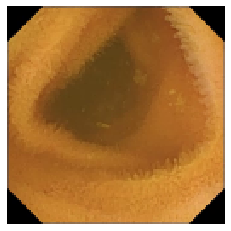

In [64]:
# Predict 1 image
image, label = next(iter(train_ds))
image = image.numpy()[0]
label = label.numpy()[0]

res = model.predict(np.expand_dims(image, axis=0))

count = 0
for number in res[0]:
    print("{:0.7f} {}".format(number,class_names[count]))
    count += 1
print()

print ("True label:", class_names[label[0]])
print ("Predicted label:", class_names[np.argmax(res[0])])

plt.figure()
plt.imshow(image)
plt.axis('off');

In [46]:
image, label = next(iter(train_ds))
image = image.numpy()
label = label.numpy()

results = model.predict(image)

idx = 0
for res in results:
    true_label = class_names[label[idx]][0]
    pred_label = class_names[np.argmax(res)]
    print ('{:3}  Label: {:20} Prediction: {}'.format(idx, true_label, pred_label))
    idx += 1

  0  Label: Normal               Prediction: Normal
  1  Label: Normal               Prediction: Normal
  2  Label: Flat lesions         Prediction: Normal
  3  Label: Normal               Prediction: Normal
  4  Label: Normal               Prediction: Normal
  5  Label: Normal               Prediction: Normal
  6  Label: Normal               Prediction: Normal
  7  Label: Normal               Prediction: Normal
  8  Label: Normal               Prediction: Normal
  9  Label: Normal               Prediction: Normal
 10  Label: Normal               Prediction: Normal
 11  Label: Normal               Prediction: Normal
 12  Label: Normal               Prediction: Normal
 13  Label: Protruding lesions   Prediction: Normal
 14  Label: Normal               Prediction: Normal
 15  Label: Normal               Prediction: Normal
 16  Label: Normal               Prediction: Normal
 17  Label: Normal               Prediction: Normal
 18  Label: Normal               Prediction: Normal
 19  Label: 